In [1]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from ccdproc import Combiner
from ccdproc import wcs_project

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

# Plot setup
matplotlib.rc('font', size=22, family='normal', weight='bold')
plt.rcParams['figure.figsize'] = [10, 4]

In [2]:
'''
Define an array of times, JD UTCs. 
These happen to be the same as the images we have, but for debugging, doesn't matter. 
'''
times = np.array([2457627.86493123, 2457627.88069257, 2457627.90520602,
                  2457627.92903088, 2457627.95309834, 2457627.97736067,
                  2457628.00173241, 2457628.02665333, 2457628.05195827,
                  2457628.07674963, 2457628.1009381 , 2457628.12582866])

In [3]:
'''
Get the EXPECTED shifts from the JPL Horizons ephemerides.
'''
from astroquery.jplhorizons import Horizons
horizons_query = Horizons(id='2015 RS281', location='568', epochs=times, id_type='smallbody')
horizons_radec = horizons_query.ephemerides(extra_precision=False)
# extra_precision=True would be better, but JPL recently broke astroquery.
shift_expected_RA = (horizons_radec['RA'] - horizons_radec['RA'][0]) * 3600
shift_expected_Dec = (horizons_radec['DEC'] - horizons_radec['DEC'][0]) * 3600
shift_expected_asec = np.array([shift_expected_RA, shift_expected_Dec]).T
shift_expected_pix = shift_expected_asec / 0.170
# 0.170 is surprisingly accurate. Using wcs is neccessary for debugging.
print(shift_expected_asec)

[[  0.      0.   ]
 [ -0.792  -0.468]
 [ -2.016  -1.188]
 [ -3.204  -1.872]
 [ -4.428  -2.592]
 [ -5.652  -3.276]
 [ -6.876  -3.996]
 [ -8.136  -4.716]
 [ -9.432  -5.472]
 [-10.692  -6.192]
 [-11.916  -6.912]
 [-13.176  -7.632]]


In [4]:
'''
Setting some initial conditions for transforming 2015 RS281.
These were obtained using Bernstein's fit_radec and an obs80 file that includes 
a measurement of the first observation as the first line (making it reference time & direction).
    K15RS1S  C2016 08 27.36490 00 41 35.095+06 39 14.91                     568
Full obs file in shifty/dev_data/K15RS1S.obs
'''
radec0 = np.array([(0 + 41./60 + 35.0957/3600) * 15, (6 + 39./60 + 14.840/3600)])  # 0:41:35.0957, +6:39:14.840
time0 = times[0]  # 2457627.86493123
abg = np.array([0.00001448, -0.00001140, 0.02444520, # alpha, beta, gamma
                0.02121046, -0.01700159, 0.00597912]) # a-dot, b-dot, g-dot

In [5]:
def radec_to_proj_matrix(radec_ref=np.array([0., 0.])):
    '''This routine returns the 3-D rotation matrix for the
    given reference ra & dec.
    # matrix is a rotation matrix that converts from ecliptic
    # vectors to the projection coordinate system.
    # The projection coordinate system has z outward,
    # x parallel to increasing ecliptic longitude, and
    # y northward, making a right-handed system
    '''
    coord_ref = SkyCoord(ra=radec_ref[0] * u.deg, dec=radec_ref[1] * u.deg,
                         distance=50 * u.au)
    # The distance assumed does not change the final result,
    # but just in case, I'm assuming 50 au above.
    x_ref, y_ref, z_ref = coord_ref.cartesian.xyz.value
    r = np.sqrt(x_ref * x_ref + y_ref * y_ref + z_ref * z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref / r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)

    matrix = np.array([[-slon0, clon0, 0], 
                    [-clon0 * slat0, -slon0 * slat0, clat0],
                    [clon0 * clat0, slon0 * clat0, slat0]])

    return matrix

In [6]:
'''
Calculate projection matrix (needed later)
'''
projection_matrix = radec_to_proj_matrix(radec0)
print(projection_matrix)

[[-0.18045446  0.98358334  0.        ]
 [-0.11397316 -0.02091024  0.99326375]
 [ 0.97695768  0.17923888  0.11587545]]


In [7]:
def get_heliocentic_equatorial_XYZ_from_JPL(times, obs_code='500',
                                            verbose=False):
    '''
    Query horizons for the EQUATORIAL heliocentric
    observatory position at a sequence of times.

    input:
    obs_code    - string
                - Note that Horizons uses some weird ones sometimes,
                  like "500@-95" for Tess.
    times       - array of JD times (UTC)
    '''
    from astroquery.jplhorizons import Horizons
    times_AP = Time(times, format='jd', scale='utc')
    # convert times to tdb, the time system used by Horizons for vectors. 
    times_tdb = times_AP.tdb.value
    horizons_query = Horizons(id='10', location=obs_code,
                              epochs=times_tdb, id_type='id')
    horizons_vector = horizons_query.vectors(refplane='earth')
    helio_OBS_equ = 0 - np.array([horizons_vector['x'], horizons_vector['y'],
                                  horizons_vector['z']]).T
    if verbose:
        print('No verbosity implemented yet, sorry')
    return helio_OBS_equ

In [8]:
'''
Get the position of the observer position. 
'''
# Observer's heliocentric equatorial location at all times.
observer_helio_equator = get_heliocentic_equatorial_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_equator0 = get_heliocentic_equatorial_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_equator_relative = observer_helio_equator - observer_helio_equator0
# Observer's location in the projection coordinate space, relative to the reference time
observer_projected = np.array([np.dot(projection_matrix, obspos) for obspos in observer_helio_equator_relative])

In [9]:
def abg2theta(timesJD, timeJD0, abg, obscode, xyz_E):
    '''
    Converts input abg to a theta vector at time dtime from reference time.
    inputs:
    -------
    abg    - array length 6 - array containing alpha, beta, gamma,
                              alpha-dot, beta-dot, gamma-dot.
    timesJD - float - times in Julian days
    '''
    # convert times to YEARS since reference time
    dtime = (timesJD - timeJD0) / 365.
    grav = [0, 0, 0]
    x_E, y_E, z_E = xyz_E.T
    num_x = abg[0] + abg[3] * dtime + abg[2] * grav[0] - abg[2] * x_E
    num_y = abg[1] + abg[4] * dtime + abg[2] * grav[1] - abg[2] * y_E
    denominator = 1 + abg[5] * dtime + abg[2] * grav[2] - abg[2] * z_E
    theta_x = num_x / denominator                       # eq 6
    theta_y = num_y / denominator                       # eq 6
    #theta_x = abg[0] + abg[3] * dtime - abg[2] * x_E   # eq 16
    #theta_y = abg[1] + abg[4] * dtime - abg[2] * y_E   # eq 16
    return np.array([theta_x, theta_y]).T

In [10]:
'''
Now get the theta values. 
'''
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec
# For some reason, the thetas aren't 0 at reference time, so subtract off the value at reference time. 
thetas_offset_asec = thetas_asec - thetas_asec[0]  # subtract off common base
# Convert to pixels
thetas_offset_pix = thetas_offset_asec / 0.170  # arcsec to pixel (accurate to <0.01")
print(thetas_asec)
print(thetas_offset_asec)

[[  2.98671439  -2.35141879]
 [  2.16034244  -2.89690038]
 [  0.8715591   -3.74577128]
 [ -0.3847289   -4.5714214 ]
 [ -1.65698033  -5.4061562 ]
 [ -2.94214946  -6.24838171]
 [ -4.23508845  -7.09517728]
 [ -5.55846903  -7.96187493]
 [ -6.90279948  -8.84278453]
 [ -8.2196083   -9.70664524]
 [ -9.50344645 -10.55026941]
 [-10.82286817 -11.41914175]]
[[  0.           0.        ]
 [ -0.82637195  -0.54548159]
 [ -2.11515529  -1.39435248]
 [ -3.37144329  -2.22000261]
 [ -4.64369472  -3.05473741]
 [ -5.92886385  -3.89696292]
 [ -7.22180284  -4.74375849]
 [ -8.54518342  -5.61045614]
 [ -9.88951388  -6.49136574]
 [-11.2063227   -7.35522645]
 [-12.49016085  -8.19885062]
 [-13.80958256  -9.06772296]]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


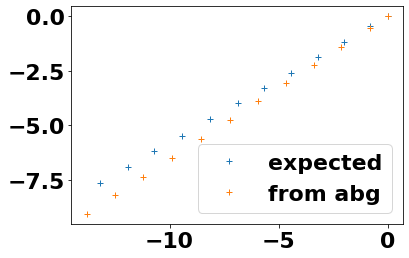

In [11]:
plt.plot(*shift_expected_asec.T, '+', label='expected')
plt.plot(*thetas_offset_asec.T, '+', label='from abg')
plt.gca().set_aspect('equal')
plt.legend()